In [49]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt

sys.path.append('../')
sys.path.append('../paretoviz')
from paretoviz import plotting as pplt
from paretoviz import decorator as dcor
from paretoviz.utils import fmt
from paretoviz.utils import vectorops as vops
from paretoviz.decorator import Arrow3D

# Do all these plots with centroid based coloring

# rawfpath = "../data/spherical/spherical-3d.out"
# rawfpath = "../data/spherical/spherical-4d.out"
# rawfpath = "../data/spherical/spherical-8d.out"

# rawfpath = "../data/knee/knee-3d.out"
# rawfpath = "../data/knee/knee-4d.out"
# rawfpath = "../data/knee/knee-8d.out"

# rawfpath = "../data/line-surface/line-3d.out"
# rawfpath = "../data/line-surface/line-4d.out"
# rawfpath = "../data/line-surface/line-6d.out"
# rawfpath = "../data/line-surface/line-8d.out"

# rawfpath = "../data/carcrash/carcrash-3d.out"
# rawfpath = "../data/carcrash/carcrash-c1/carcrash-c1-3d.out"
# rawfpath = "../data/carcrash/carcrash-c2/carcrash-c2-3d.out"

# Do all these plots with constraint based coloring

# rawfpath = "../data/knee-const/knee-const-3d.out"
# rawfpath = "../data/knee-const/knee-const-4d.out"
# rawfpath = "../data/knee-const/knee-const-8d.out"

# rawfpath = "../data/knee-const-mod/knee-const-mod-3d.out"
# rawfpath = "../data/knee-const-mod/knee-const-mod-4d.out"

# rawfpath = "../data/isolated/isolated-3d.out"
# rawfpath = "../data/isolated/isolated-4d.out"
# rawfpath = "../data/isolated/isolated-8d.out"

# rawfpath = "../data/c2dtlz2/c2dtlz2-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-4d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-5d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-8d.out"

# rawfpath = "../data/c2dtlz2/c2dtlz2-c1/c2dtlz2-c1-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-c2/c2dtlz2-c2-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-c3/c2dtlz2-c3-3d.out"
# rawfpath = "../data/c2dtlz2/c2dtlz2-c4/c2dtlz2-c4-3d.out"

# rawfpath = "../data/gaa-das/gaa-das-10d.out"
# rawfpath = "../data/gaa-lhs/gaa-lhs-10d.out"

# rawfpath = "../data/osy/osy-3d.out"
rawfpath = "../data/osy/osy-4d.out"

# some ML data sets
# rawfpath = "../data/airofoil/airofoil-5d.out"
# rawfpath = "../data/banknote/banknote-4d.out"
# rawfpath = "../data/blood/blood-4d.out"
# rawfpath = "../data/cccp/cccp-4d.out"
# rawfpath = "../data/concrete/concrete-8d.out"
# rawfpath = "../data/iris/iris-4d.out"
# rawfpath = "../data/mammogram/mammogram-5d.out"
# rawfpath = "../data/wil/wil-7d.out"
# rawfpath = "../data/yeast/yeast-8d.out"

# do visualization based on distance from the centroid?
docentroid = False

# get the path and filename from the rawfpath
path, rawfile = os.path.split(rawfpath)
# get the prefix
prefix = rawfile.split('.')[0]

# load the normalized points
points = fmt.load(os.path.join(path, prefix + "-norm.out"))

# load the CV values
cvfpath = os.path.join(path, prefix + "-cv.out")
if not docentroid and os.path.exists(cvfpath):
    cv = [v[0] if len(v) == 1 else v for v in fmt.load(cvfpath)]
    [low, up] = vops.get_bound(cv)
    cv = vops.normalize(cv, low, up)
    color = dcor.recolor_by_cv(cv)
else:
    color = dcor.recolor_by_centroid(points)

# load the normalized trade-off values
mufpath = os.path.join(path, prefix + "-norm-mu.out")
knee_idx = None
if os.path.exists(mufpath):
    mu = [v[0] if len(v) == 1 else v for v in fmt.load(mufpath)]
    # resize the points w.r.t. trade-offs
    size = dcor.rescale_by_tradeoff(mu)
    (color, knee_idx) = dcor.recolor_by_tradeoff(size, color)

# load the class labels
classfpath = os.path.join(path, prefix + "-class.out")
if os.path.exists(classfpath):
    labels = [v[0] if len(v) == 1 else v for v in \
            fmt.load(classfpath, dtype = dcor.dtypes[prefix])]
    color = dcor.recolor_by_labels(labels, dtype = dcor.dtypes[prefix])
    size = [5.0 for _ in range(len(points))]

# alpha values
alpha = [0.2, 0.8] # alpha for plots with knee
# alpha = [1.0, 1.0] # alpha for general case

In [50]:
# Now change the colors w.r.t. design variable principles.
import math

"""
The rules look like this:
Region        x0            x1            x2            x4
AB (rule0)    5             1             [1,5]         5
BC (rule1)    5             1             [1,5]         1
CD (rule2)    [4.056,5]     (x0 - 2)/3    1             1
DE (rule3)    0             2             [1,3.372]     1
EF (rule4)    [0,1]         (2 - x0)      1             1

0 <= x0, x1, x5 <= 10
1 <= x2, x4 <= 5
0 <= x3 <= 6
"""

def rule0(x):
    return math.fabs(5.0 - x[0]) < 0.75 \
        and math.fabs(1.0 - x[1]) < 0.25 \
            and math.fabs(5.0  - x[4]) < 0.75

def rule1(x):
    return math.fabs(5.0 - x[0]) < 0.75 \
        and math.fabs(1.0 - x[1]) < 0.25 \
            and math.fabs(1.0  - x[4]) < 0.75

def rule2(x):
    return (4.056 <= x[0] <= (5 + 0.5)) \
            and math.fabs((x[0] - 2) / 3 - x[1]) < 0.25 \
                and math.fabs(1.0 - x[2]) < 0.25 \
                    and math.fabs(1.0 - x[4]) < 0.25

def rule3(x):
    return x[0] < 0.1 \
            and math.fabs(x[1] - 2) < 0.25 \
                and ((1.0 - 0.25) <= x[2] <= (3.732 + 0.1)) \
                    and math.fabs(1.0 - x[4]) < 0.25

def rule4(x):
    return (0.0 <= x[0] <= (1 + 0.25)) \
            and math.fabs(x[1] - (2 - x[0])) < 0.25 \
                and math.fabs(1.0 - x[2]) < 0.25 \
                    and math.fabs(1.0 - x[4]) < 0.25

xvals = points = fmt.load(os.path.join(path, prefix + "-x.out"))

parts = [[],[],[],[],[]]
outliers = []
for i,x in enumerate(xvals):
    if rule0(x):
        parts[0].append(i)
    elif rule1(x):
        parts[1].append(i)
    elif rule2(x):
        parts[2].append(i)
    elif rule3(x):
        parts[3].append(i)
    elif rule4(x):
        parts[4].append(i)
    else:
        outliers.append(i)

for i in range(len(parts)):
    print("parts[{0:d}]:".format(i), parts[i])
print("outliers:", outliers)
    
for i in range(len(parts)):
    for j in range(len(parts)):
        if i != j:
            print("parts[{0:d}] ^ parts[{1:d}]:".format(i,j), \
                  set(parts[i]).intersection(set(parts[j])))

palettes = ['red', 'green', 'blue', 'pink', 'cyan', 'black']

for i,part in enumerate(parts):
    for j in part:
        color[j] = palettes[i]
for i in outliers:
    color[i] = palettes[-1]

parts[0]: [2, 20, 23, 29, 32, 46, 49, 66, 86, 87, 95, 111, 113, 136, 140, 147, 155, 161, 169, 175, 203, 216, 217, 234, 237, 239, 242, 244, 247, 254, 263, 272, 275, 278, 298, 311, 313, 318, 321, 326, 339, 349, 362, 387, 404]
parts[1]: [17, 26, 35, 58, 78, 91, 96, 126, 146, 148, 150, 158, 163, 168, 174, 179, 221, 241, 246, 265, 269, 290, 307, 328, 361, 372, 377, 379, 392, 418]
parts[2]: [177]
parts[3]: [185]
parts[4]: [0, 25, 416]
outliers: [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 22, 24, 27, 28, 30, 31, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 88, 89, 90, 92, 93, 94, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 141, 142, 143, 144, 145, 149, 151, 152, 153, 154, 156, 157, 159,

<IPython.core.display.Javascript object>


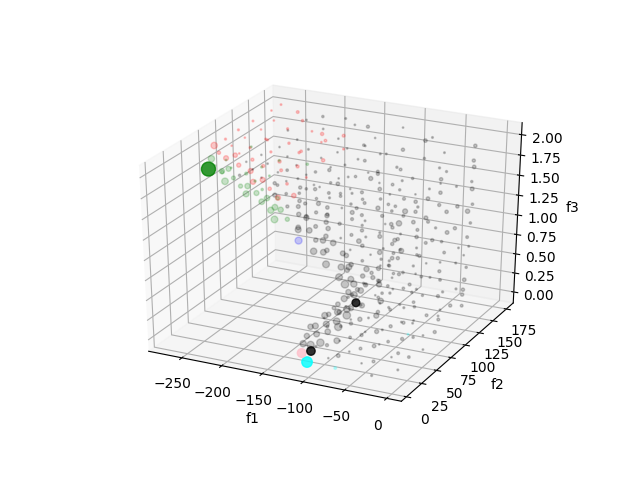

In [51]:
# use the original obj values for scatter plot.
rawpoints = fmt.load(rawfpath)
# do the scatter plot
(fig, ax) = pplt.scatter(rawpoints, s = size, c = color, alpha = alpha, \
                camera = dcor.cam_scatter[prefix], knee_idx = knee_idx)
# save the scatter plot
scatterfpath = os.path.join(".", prefix + "-scatter.pdf")
plt.savefig(scatterfpath, transparent = False)

plt.show()

<IPython.core.display.Javascript object>


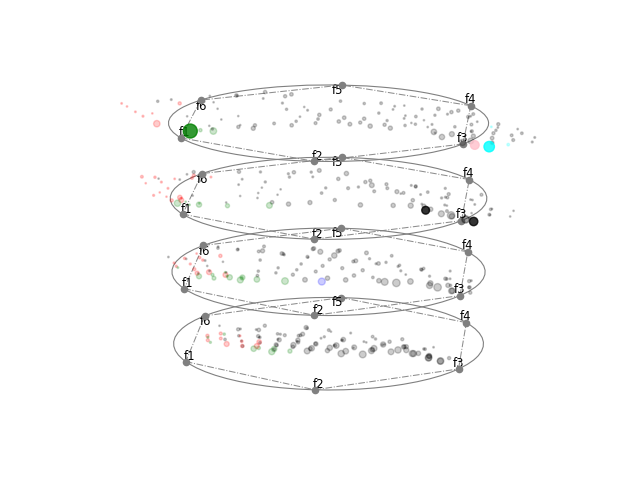

In [52]:
# Show the generic paletteviz
palette_coords = fmt.load(os.path.join(path, prefix + "-norm-palette-invsc.out"))

# do the paletteviz plot
(fig, ax) = pplt.paletteviz(palette_coords, dim = len(points[0]), \
            s = size, c = color, alpha = alpha, camera = dcor.cam_palette[prefix], \
            knee_idx = knee_idx, mode = "sc")
# save the paletteviz plot
fig.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, wspace = 0, hspace = 0)
palettefpath = os.path.join(".", prefix + "-norm-palette-invsc.pdf")
plt.savefig(palettefpath, transparent = False, bbox_inches = 'tight', pad_inches = 0)

plt.show()